In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
import mpl_toolkits
import seaborn as sns
from scipy.stats import norm, skew
import random 
import warnings
warnings.filterwarnings('ignore')

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize  
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/citizens/Citizens"))

# Any results you write to the current directory are saved as output.

['citizens']
['datathon_propattributes.csv', 'datathon_propattributes.obj', 'demoNotebook.html', 'FileLayout.xlsx', 'demoNotebook.ipynb']


In [2]:
%matplotlib inline
path = '../input/citizens/Citizens'

#Read in the data
data = open(path + '/datathon_propattributes.obj', 'rb')
data = pickle.load(data)

pd.set_option('display.max_rows', 200)

In [3]:
#data_original = data.copy()
print ("Size of data : {}" .format(data.shape))

Size of data : (4413212, 74)


## Feature engineering
#### The following columns are dropped either due to large missing ratio or not helpful for prediction of hourse price.

In [4]:
data.columns

Index(['fips_cd', 'apn', 'IsTraining', 'prop_house_number',
       'prop_house_number_2', 'prop_house_number_suffix',
       'prop_direction_left', 'prop_street_name', 'prop_suffix',
       'prop_direction_right', 'prop_unit_type', 'prop_unit_number',
       'prop_city', 'prop_state', 'prop_zip_code', 'prop_zip_plus_4',
       'dwelling_type', 'zoning', 'census_tract', 'mobile_home_ind',
       'timeshare_ind', 'acres', 'land_square_footage', 'irregular_lot_flg',
       'assessed_total_value', 'assessed_land_value',
       'assessed_improvement_value', 'market_total_value', 'market_land_value',
       'market_improvement_value', 'tax_amt', 'tax_year',
       'delinquent_tax_year', 'assessed_year', 'tax_cd_area',
       'building_square_feet', 'total_living_square_feet',
       'total_ground_floor_square_feet', 'total_basement_square_feet',
       'total_garage_parking_square_feet', 'year_built',
       'effective_year_built', 'bedrooms', 'total_rooms',
       'total_baths_calculated', 

In [5]:
#columns are deleted because 'transaction_date' has corresponding 'transaction_dt' column
# and 'IsTraining' does not contain any useful information
columns_to_drop3 = ['transaction_date','IsTraining'] 


for col in columns_to_drop3:
    data.drop(col,axis = 1,inplace = True)

# columns with 'avm' are only available for training samples and not available for testing samples. 
# They are also dropped for consistance.
col_avm = []
for col in data.columns:
    if 'avm' in col:
        col_avm.append(col)
        
for col in col_avm:
    data.drop(col,axis = 1,inplace = True)

In [6]:
data['transaction_year'] = data['transaction_dt'].apply(lambda x: x.year)

In [7]:
mindatetime = min(data['transaction_dt'])
data['transaction_dt'] = (data['transaction_dt'] - mindatetime)
data['transaction_dt'] = data['transaction_dt'].apply(lambda x: x.days)

In [8]:
# def check_skewness(col):
#     sns.distplot(data[col] , fit=norm);
#     fig = plt.figure()
#     res = stats.probplot(data[col], plot=plt)
#     # Get the fitted parameters used by the function
#     (mu, sigma) = norm.fit(data[col])
#     print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
# check_skewness('sale_amt')

## Split data into subdatasets

In [9]:
data['prop_state'].unique()

array(['PA', 'RI', 'MA'], dtype=object)

In [10]:
# split dataset into three subsets. Because some features are not contained for all the states.
dataRI = data[data['prop_state'] == 'RI']
dataPA = data[data['prop_state'] == 'PA']
dataMA = data[data['prop_state'] == 'MA']
len(dataRI),len(dataPA),len(dataMA)

(224059, 2817134, 1372019)

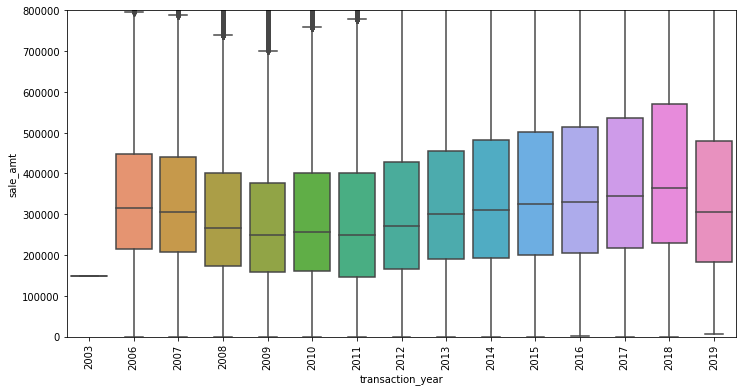

In [11]:
var = 'transaction_year'
data_year = pd.concat([dataMA['sale_amt'], dataMA[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="sale_amt", data=data_year)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

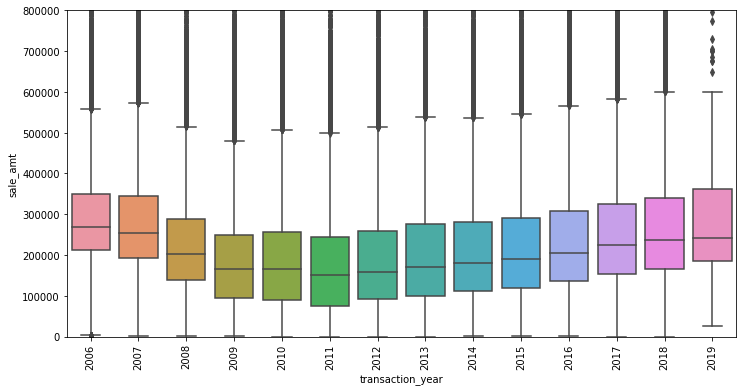

In [12]:
var = 'transaction_year'
data_year = pd.concat([dataRI['sale_amt'], dataRI[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="sale_amt", data=data_year)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

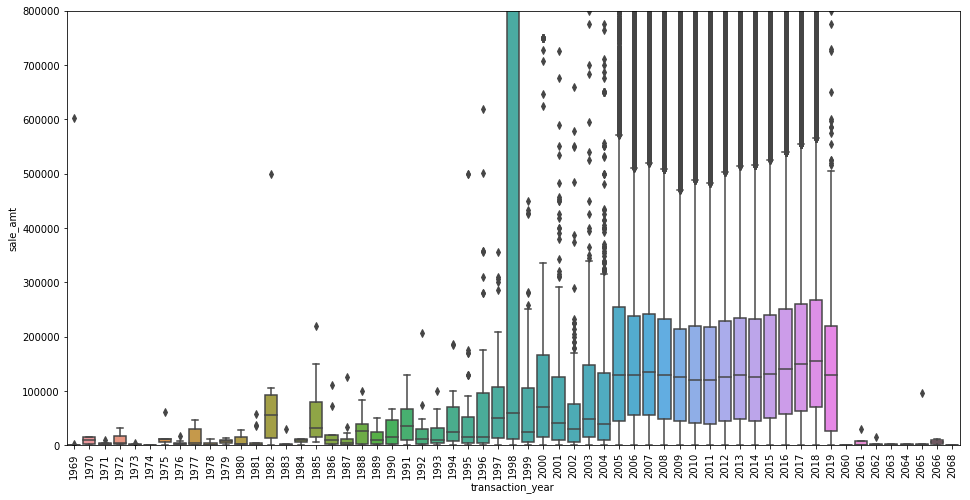

In [13]:
var = 'transaction_year'
data_year = pd.concat([dataPA['sale_amt'], dataPA[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="sale_amt", data=data_year)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Since dataPA requires most data-cleans process, please refer to kernel [https://www.kaggle.com/zhyaqi/house-price-prediction-pa] for reference. 

## MA data

In [14]:
dataMAdesc = pd.DataFrame((dataMA.isnull().sum() / len(dataMA)) * 100, columns = ['missing_ratio'])
dataMAdesc['data_type'] = dataMA.dtypes
dataMAdesc['number_unique'] = np.nan
dataMAdesc['zeros_ratio'] = np.nan
for col in dataMA.columns:
    if (dataMAdesc['data_type'].loc[col] == 'object'):
        dataMAdesc.loc[[col],['number_unique']] = len(dataMA[col].value_counts())
    else:
        dataMAdesc.loc[[col],['zeros_ratio']] = sum(dataMA[col] == 0)/len(dataMA)*100
dataMAdesc['number_unique_ratio'] = dataMAdesc['number_unique']/len(data)*100
dataMAdesc

,missing_ratio,data_type,number_unique,zeros_ratio,number_unique_ratio
fips_cd,0.000000,object,14.0,NaN,0.000317
apn,0.000000,object,907031.0,NaN,20.552627
prop_house_number,0.642994,object,7926.0,NaN,0.179597
prop_house_number_2,99.999563,object,1.0,NaN,0.000023
prop_house_number_suffix,100.000000,object,0.0,NaN,0.000000
prop_direction_left,96.869796,object,8.0,NaN,0.000181
prop_street_name,0.005831,object,25631.0,NaN,0.580779
prop_suffix,0.997362,object,97.0,NaN,0.002198
prop_direction_right,99.660282,object,5.0,NaN,0.000113
prop_unit_type,82.831579,object,25.0,NaN,0.000566


In [15]:
# large missing ratio
columns_to_drop = ['prop_house_number_2', 'prop_house_number_suffix', 'prop_direction_left','prop_direction_right',
                   'irregular_lot_flg','tax_cd_area','prop_unit_number','prop_unit_type','mobile_home_ind','timeshare_ind',
                   'garage_type','construction_quality']
# only zeros in the columns
columns_to_drop2 = ['market_total_value','market_improvement_value','market_land_value','total_garage_parking_square_feet']
# too many unique values and not helpful with predictions
columns_to_drop4 = ['apn','prop_house_number','prop_street_name','prop_suffix','prop_zip_plus_4']

In [16]:
for col in columns_to_drop:
    dataMA.drop(col,axis = 1,inplace = True)
for col in columns_to_drop2:
    dataMA.drop(col,axis = 1,inplace = True)
for col in columns_to_drop4:
    dataMA.drop(col,axis = 1,inplace = True)

In [17]:
dataMA.shape

(1372019, 42)

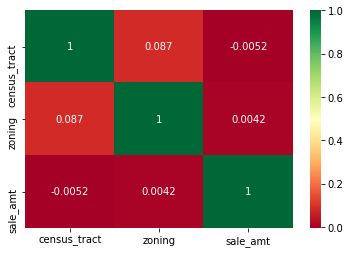

In [18]:
# 'census_tract', 'zoning' are all location related. I would like to see the correlation between them.
dataMAnew = pd.DataFrame()
dataMAnew['census_tract'] = pd.factorize(dataMA['census_tract'])[0]
dataMAnew['zoning'] = pd.factorize(dataMA['zoning'])[0]
dataMAnew['sale_amt'] = pd.factorize(dataMA['sale_amt'])[0]
corrmat = dataMAnew.corr()
plt.figure()
g = sns.heatmap(corrmat,cmap="RdYlGn",annot=True)

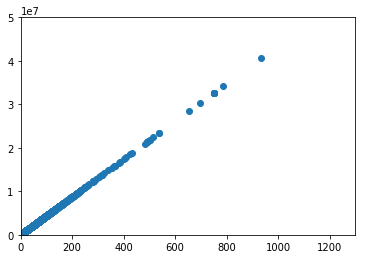

In [19]:
plt.scatter(dataMA['acres'],dataMA['land_square_footage'])
plt.xlim([0, 1300])
plt.ylim([0, 5*10000000])
plt.show()

In [20]:
# There is linear relation between 'acres' and 'land_square_footage'. Drop 'acres'
dataMA.drop('acres',axis = 1,inplace = True)
dataMA.drop('prop_state',axis = 1,inplace = True)

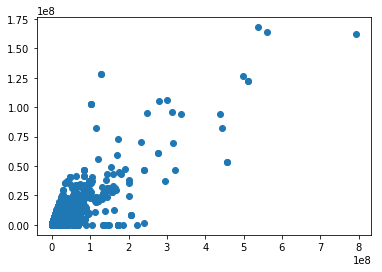

In [21]:
plt.scatter(dataMA['assessed_total_value'],dataMA['assessed_land_value'])
plt.show()

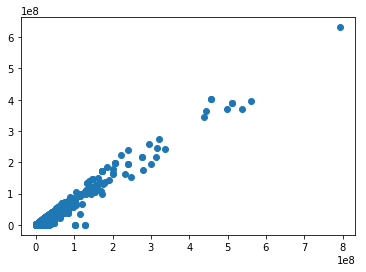

In [22]:
plt.scatter(dataMA['assessed_total_value'],dataMA['assessed_improvement_value'])
plt.show()

There are some correlations between 'assessed_total_value' and 'assessed_land_value'. But it is not simple linear relation. I would keep both of them. Same argument holds for 'assessed_total_value' and 'assessed_improvement_value'.

In [23]:
numeric_feats = dataMA.dtypes[dataMA.dtypes != "object"].index
for col in numeric_feats:
    #print(col)
    if col != 'geocode_longitude':
        dataMA[col] = np.log1p(dataMA[col])
    else:
        dataMA[col] = np.log1p(dataMA[col] - min(dataMA[col]))

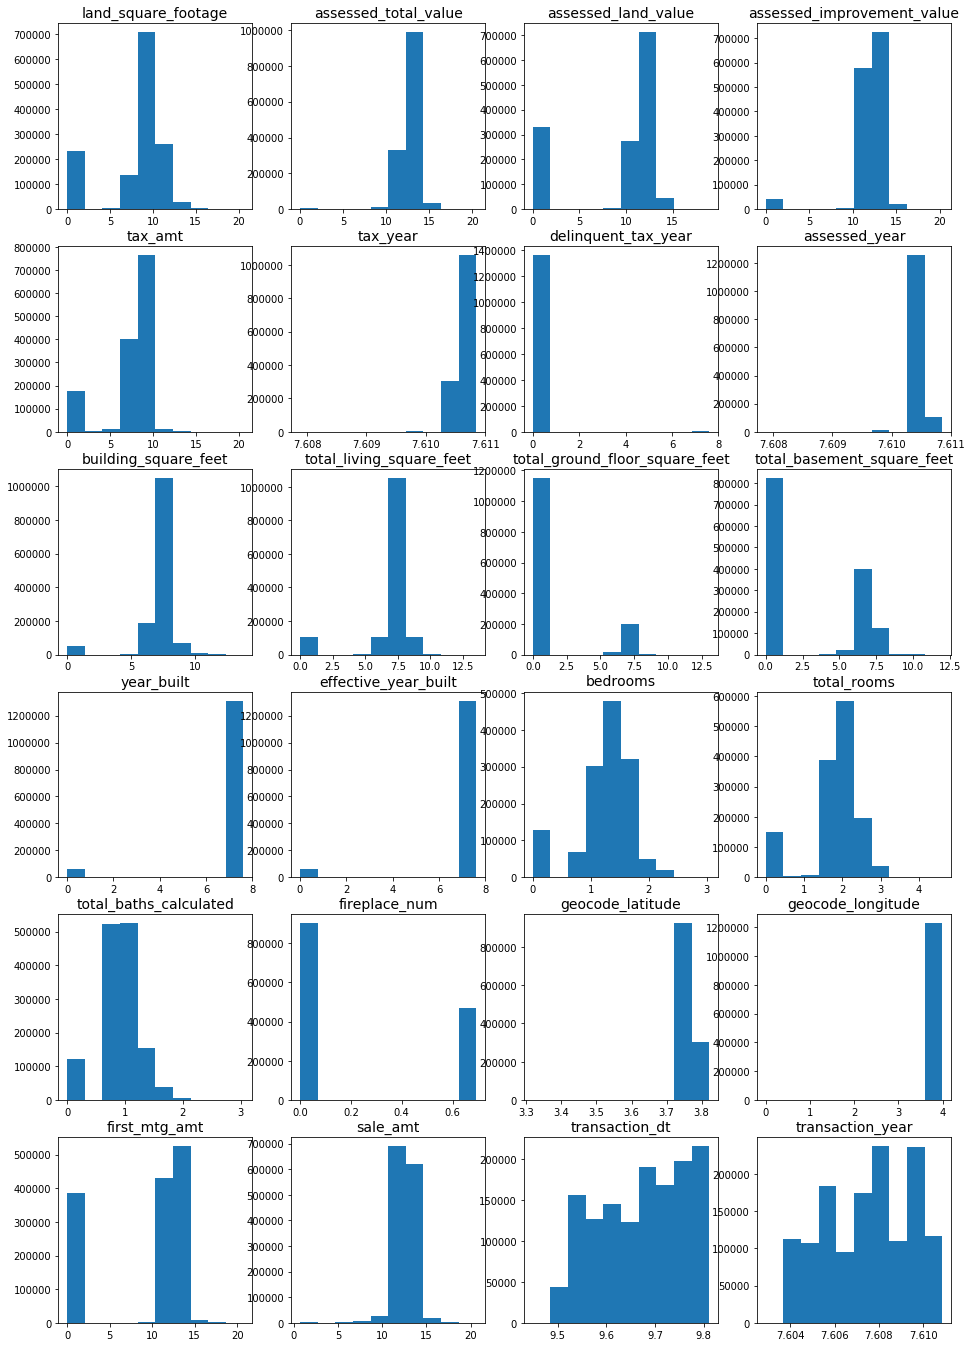

In [24]:
def plot_images(imgs, labels, cols=3):
    # Set figure to 13 inches x 8 inches

    rows = len(imgs) // cols + 1
    figure = plt.figure(figsize=(16, 4*rows))
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        #subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=14)
        subplot.hist(imgs[i])

#plot_images(plt.hist(np.log1p(data[numeric_feats[1]])), [])
imgs = []       
labels = []
for col in numeric_feats:
    imgs.append(dataMA[col])
    labels.append(col)
plot_images(imgs, labels, cols=4)

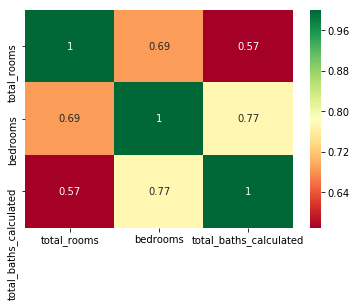

In [25]:
corrmat = dataMA[['total_rooms','bedrooms','total_baths_calculated']].corr()
plt.figure()
g = sns.heatmap(corrmat,cmap="RdYlGn",annot=True)

In [26]:
# for some of the columns, it does not make sense to have zero values. I will try to delete those rows.
columns = ['land_square_footage', 'assessed_total_value', 'assessed_land_value', 'assessed_improvement_value',
          'building_square_feet', 'total_rooms']
data_new = dataMA.copy()

for col in columns:
    data_new[col] = data_new[col].where(data_new[col] > 0, np.nan)
    data_new.dropna(subset=[col], inplace = True, axis = 0)
    print(col, len(data_new)/len(dataMA))

data_new.drop(data_new[(data_new['year_built'] == 0) & (data_new['effective_year_built'] == 0)].index, inplace = True)

land_square_footage 0.8304425813345151
assessed_total_value 0.825395275138318
assessed_land_value 0.7585448889556194
assessed_improvement_value 0.7343061575677888
building_square_feet 0.721813619199151
total_rooms 0.6676452731339726


In [27]:
# Fill the nan in the numeric columns with mean of the column.
numeric_feats = data_new.dtypes[dataMA.dtypes != "object"].index
for col in numeric_feats:
    if data_new[col].isnull().sum() > 0:
        print(col)
        data_new[col].fillna((data_new[col].mean()))

geocode_latitude
geocode_longitude
first_mtg_amt


### split data into train and test datasets

In [28]:
# The data is splitted by date. Entries before 2018-10-01 is training data and after 2018-10-01 is test data.
checkdate = pd.to_datetime('2018-10-01')
datetimediff = np.log1p((checkdate - mindatetime).days)

checkdateend = pd.to_datetime('2018-12-31')
datetimeenddiff = np.log1p((checkdateend - mindatetime).days)
testset = data_new[(data_new['transaction_dt'] >= datetimediff)&(data_new['transaction_dt'] < datetimeenddiff)]
trainset = data_new[data_new['transaction_dt'] < datetimediff]

train_X = trainset.copy()
train_X.drop('sale_amt',axis = 1, inplace = True)
train_Y = trainset['sale_amt']

test_X = testset.copy()
test_X.drop('sale_amt',axis = 1, inplace = True)
test_Y = testset['sale_amt']

In [29]:
train_X.shape,test_X.shape

((889553, 39), (19373, 39))

In [30]:
N1 = len(train_X)
indices = np.arange(len(trainset))
selind = random.sample(list(indices), N1)
train_X_use = train_X.iloc[selind]
train_Y_use = train_Y.iloc[selind]

In [31]:
N2 = len(test_X)
indices = np.arange(len(testset))
selind = random.sample(list(indices), N2)
test_X_use = test_X.iloc[selind]
test_Y_use = test_Y.iloc[selind]

In [32]:
# factorize the categorical columns. For columns with too many unique values, get_dummies would result in dataset with too 
# many columns. I just used factorize to transform these columns. For other columns, I used get_dummies to do the 
# transformation.

feats = ['prop_city','prop_zip_code','census_tract','zoning']
cat_feats = list(train_X_use.dtypes[train_X_use.dtypes == "object"].index)
train_test = pd.concat([train_X_use, test_X_use], ignore_index=True)
for col in feats:
    train_test[col] = pd.factorize(train_test[col], sort = True)[0]
    cat_feats.remove(col)
train_test = pd.get_dummies(train_test, dummy_na = 'True', prefix = cat_feats)
#train_test = RobustScaler().fit_transform(train_test)
# RobustScaler is not quite helpful for random forest model.

In [33]:
train_X_use = train_test[:N1]
test_X_use = train_test[N1:]
train_X_use.shape

(889553, 233)

In [34]:
from lightgbm import LGBMRegressor

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=40,#4, 10, 20, 30, 50, 80
                                       learning_rate=0.01, #0.01, 0.002
                                       n_estimators=5000,
                                       max_bin=1000, # 200
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.8, #0.2
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
lightgbm.fit(train_X_use, train_Y_use)

y_predict = lightgbm.predict(test_X_use)
train_pre = lightgbm.predict(train_X_use)

#### Results

In [35]:
# Results are shown for the percentage that the prediction is within 10% error of the true trading prices. 

thresh = 0.1
pererror = []
counts = 0
labels = list(train_Y_use)
for i in range(len(train_pre)):
    pererror.append((np.expm1(train_pre[i])-np.expm1(labels[i]))/np.expm1(labels[i]))
    if np.abs(pererror[i]) < thresh:
        counts += 1
print('train', counts/len(train_pre))

pererror = []
counts = 0
labels = list(test_Y_use)
for i in range(len(y_predict)):
    pererror.append((np.expm1(y_predict[i])-np.expm1(labels[i]))/np.expm1(labels[i]))
    if np.abs(pererror[i]) < thresh:
        counts += 1
print('test', counts/len(y_predict))

train 0.495297076171965
test 0.5291384917152738


#### Importance of features

In [36]:
importantce_list = list(zip(train_test.columns, lightgbm.feature_importances_))
def takeSecond(elem):
    return elem[1]
importantce_list.sort(key=takeSecond, reverse=True)
importantce_list[:20]

[('transaction_dt', 21478),
 ('first_mtg_amt', 13938),
 ('geocode_longitude', 11164),
 ('land_square_footage', 10897),
 ('assessed_land_value', 10775),
 ('geocode_latitude', 10633),
 ('year_built', 10346),
 ('assessed_total_value', 9018),
 ('assessed_improvement_value', 7892),
 ('census_tract', 7745),
 ('effective_year_built', 7027),
 ('building_square_feet', 6640),
 ('tax_amt', 6356),
 ('prop_zip_code', 5934),
 ('distressed_sale_flg_Y', 5746),
 ('prop_city', 4574),
 ('zoning', 4225),
 ('total_basement_square_feet', 3596),
 ('total_living_square_feet', 3449),
 ('total_rooms', 3205)]

#### Histograms of predictions and true prices

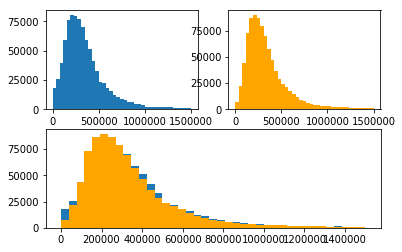

In [37]:
labels = list(train_Y_use)
#range = (0, 1000000)
bins = np.linspace(0,1500000,40)
plt.subplot(2, 2, 1)
plt.hist(np.expm1(labels),bins= bins)
plt.subplot(2, 2, 2)
plt.hist(np.expm1(train_pre), bins = bins, color = 'orange')
plt.subplot(212)
plt.hist(np.expm1(labels),bins= bins)
plt.hist(np.expm1(train_pre), bins = bins, color = 'orange')
plt.show()

## RI data

In [38]:
dataRIdesc = pd.DataFrame((dataRI.isnull().sum() / len(dataRI)) * 100, columns = ['missing_ratio'])
dataRIdesc['data_type'] = dataRI.dtypes
dataRIdesc['number_unique'] = np.nan
dataRIdesc['zeros_ratio'] = np.nan
for col in dataRI.columns:
    if (dataRIdesc['data_type'].loc[col] == 'object'):
        dataRIdesc.loc[[col],['number_unique']] = len(dataRI[col].value_counts())
    else:
        dataRIdesc.loc[[col],['zeros_ratio']] = sum(dataRI[col] == 0)/len(dataRI)
dataRIdesc['number_unique_ratio'] = dataRIdesc['number_unique']/len(data)
dataRIdesc

,missing_ratio,data_type,number_unique,zeros_ratio,number_unique_ratio
fips_cd,0.000000,object,5.0,NaN,1.132962e-06
apn,0.000000,object,143415.0,NaN,3.249674e-02
prop_house_number,0.857363,object,4152.0,NaN,9.408114e-04
prop_house_number_2,99.987503,object,1.0,NaN,2.265923e-07
prop_house_number_suffix,100.000000,object,0.0,NaN,0.000000e+00
prop_direction_left,97.572068,object,5.0,NaN,1.132962e-06
prop_street_name,0.002678,object,7926.0,NaN,1.795971e-03
prop_suffix,0.576188,object,56.0,NaN,1.268917e-05
prop_direction_right,99.754529,object,4.0,NaN,9.063693e-07
prop_unit_type,91.962385,object,11.0,NaN,2.492516e-06


In [39]:
# large missing ratio
columns_to_drop = ['prop_house_number_2', 'prop_house_number_suffix', 'prop_direction_left','prop_direction_right',
                   'irregular_lot_flg','tax_cd_area','prop_unit_number','prop_unit_type','mobile_home_ind','timeshare_ind',
                   'garage_type','construction_quality']
# only zeros in the columns
columns_to_drop2 = ['market_total_value','market_improvement_value','market_land_value','total_garage_parking_square_feet','delinquent_tax_year']
# too many unique values and not helpful with predictions
columns_to_drop4 = ['apn','prop_house_number','prop_street_name','prop_suffix','prop_zip_plus_4']

In [40]:
for col in columns_to_drop:
    dataRI.drop(col,axis = 1,inplace = True)
for col in columns_to_drop2:
    dataRI.drop(col,axis = 1,inplace = True)
for col in columns_to_drop4:
    dataRI.drop(col,axis = 1,inplace = True)

In [41]:
print ("Size of dataRI : {}" .format(dataRI.shape))

Size of dataRI : (224059, 41)


In [42]:
dataRI.drop('acres', axis = 1, inplace=True)
dataRI.drop('prop_state', axis = 1, inplace=True)

In [43]:
numeric_feats = dataRI.dtypes[dataRI.dtypes != "object"].index
for col in numeric_feats:
    #print(col)
    if col != 'geocode_longitude':
        dataRI[col] = np.log1p(dataRI[col])
    else:
        dataRI[col] = np.log1p(dataRI[col] - min(dataRI[col]))

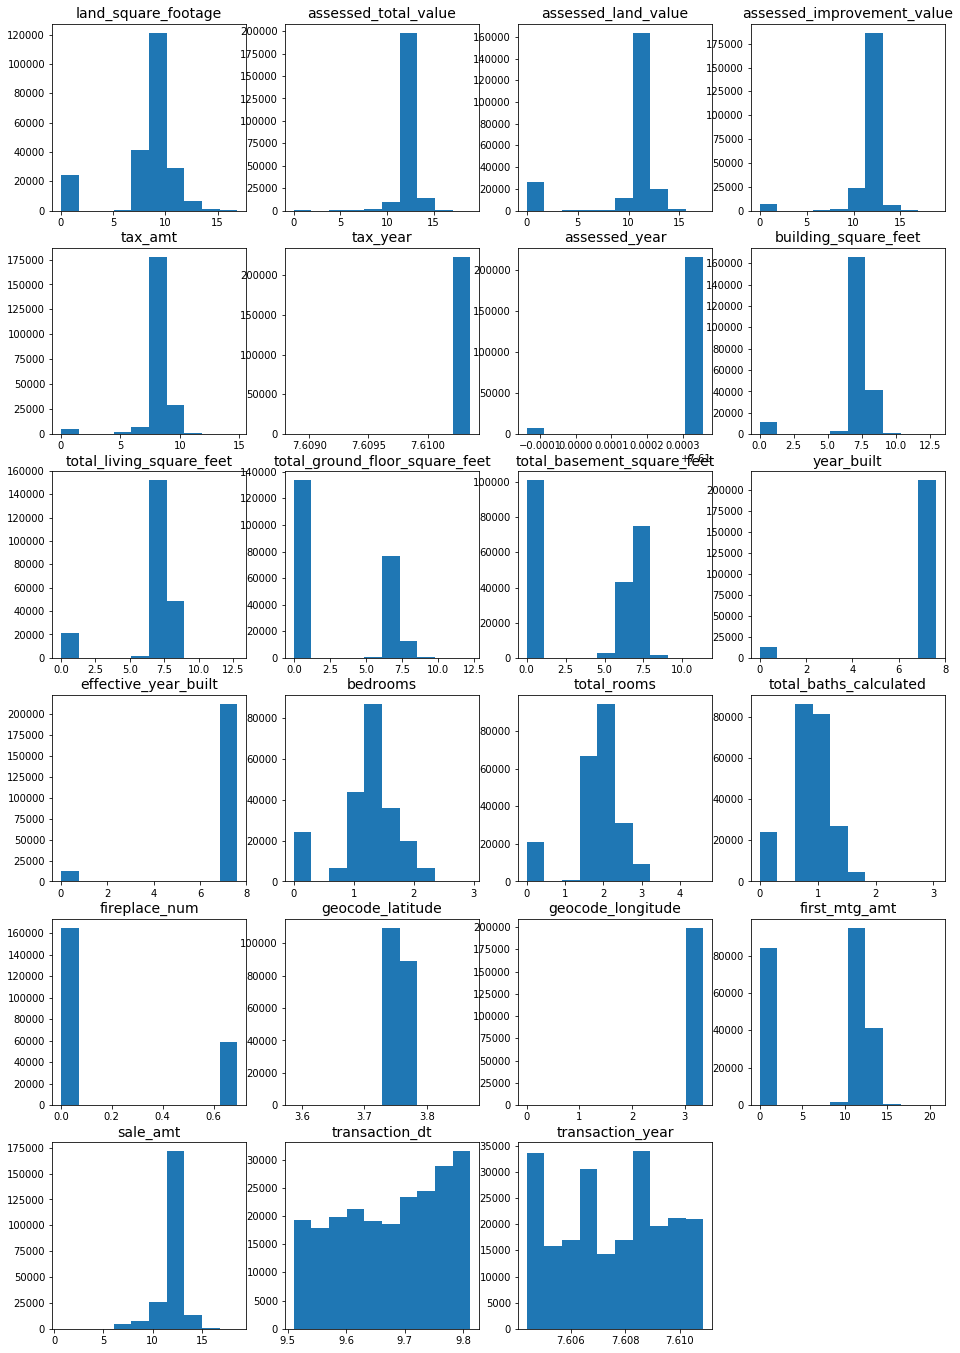

In [44]:
def plot_images(imgs, labels, cols=3):
    # Set figure to 13 inches x 8 inches

    rows = len(imgs) // cols + 1
    figure = plt.figure(figsize=(16, 4*rows))
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        #subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=14)
        #print(subplot)
        subplot.hist(imgs[i])

#plot_images(plt.hist(np.log1p(data[numeric_feats[1]])), [])
imgs = []       
labels = []
for col in numeric_feats:
    imgs.append(dataRI[col])
    labels.append(col)
plot_images(imgs, labels, cols=4)

In [45]:
# for some of the columns, it does not make sense to have zero values. I will try to delete those rows.
columns = ['land_square_footage', 'assessed_total_value', 'assessed_land_value', 'assessed_improvement_value',
          'building_square_feet', 'total_rooms']
data_new = dataRI.copy()

# for col in columns:
#     data_new[col] = data_new[col].where(data_new[col] > 0, np.nan)
#     data_new.dropna(subset=[col], inplace = True, axis = 0)
#     print(len(data_new)/len(dataRI))

# data_new.drop(data_new[(data_new['year_built'] == 0) & (data_new['effective_year_built'] == 0)].index, inplace = True)

In [46]:
numeric_feats = data_new.dtypes[dataMA.dtypes != "object"].index
for col in numeric_feats:
    if data_new[col].isnull().sum() > 0:
        print(col)
        data_new[col].fillna((data_new[col].mean()),inplace = True)

geocode_latitude
geocode_longitude
first_mtg_amt


In [47]:
checkdate = pd.to_datetime('2018-10-01')
datetimediff = np.log1p((checkdate - mindatetime).days)

checkdateend = pd.to_datetime('2018-12-31')
datetimeenddiff = np.log1p((checkdateend - mindatetime).days)
testset = data_new[(data_new['transaction_dt'] >= datetimediff)&(data_new['transaction_dt'] < datetimeenddiff)]
trainset = data_new[data_new['transaction_dt'] < datetimediff]

train_X = trainset.copy()
train_X.drop('sale_amt',axis = 1, inplace = True)
train_Y = trainset['sale_amt']

test_X = testset.copy()
test_X.drop('sale_amt',axis = 1, inplace = True)
test_Y = testset['sale_amt']

In [48]:
train_X.shape, test_X.shape

((218782, 38), (5092, 38))

In [49]:
N1 = len(train_X)
indices = np.arange(len(trainset))
selind = random.sample(list(indices), N1)
train_X_use = train_X.iloc[selind]
train_Y_use = train_Y.iloc[selind]

N2 = len(test_X)
indices = np.arange(len(testset))
selind = random.sample(list(indices), N2)
test_X_use = test_X.iloc[selind]
test_Y_use = test_Y.iloc[selind]

In [50]:
feats = ['prop_city','prop_zip_code','census_tract','zoning']
cat_feats = list(train_X_use.dtypes[train_X_use.dtypes == "object"].index)
train_test = pd.concat([train_X_use, test_X_use], ignore_index=True)
for col in feats:
    train_test[col] = pd.factorize(train_test[col], sort = True)[0]
    cat_feats.remove(col)
train_test = pd.get_dummies(train_test, dummy_na = 'True', prefix = cat_feats)

In [51]:
train_X_use = train_test[:N1]
test_X_use = train_test[N1:]
train_X_use.shape

(218782, 205)

In [52]:
from lightgbm import LGBMRegressor

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=40,#4, 10, 20, 30, 50, 80
                                       learning_rate=0.01, #0.01, 0.002
                                       n_estimators=5000,
                                       max_bin=1000, # 200
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.8, #0.2
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
lightgbm.fit(train_X_use, train_Y_use)

y_predict = lightgbm.predict(test_X_use)
train_pre = lightgbm.predict(train_X_use)

#### Results

In [53]:
# Results are shown for the percentage that the prediction is within 10% error of the true trading prices. 
thresh = 0.1
pererror = []
counts = 0
labels = list(train_Y_use)
for i in range(len(train_pre)):
    pererror.append((np.expm1(train_pre[i])-np.expm1(labels[i]))/np.expm1(labels[i]))
    if np.abs(pererror[i]) < thresh:
        counts += 1
print('train', counts/len(train_pre))

pererror = []
counts = 0
labels = list(test_Y_use)
for i in range(len(y_predict)):
    pererror.append((np.expm1(y_predict[i])-np.expm1(labels[i]))/np.expm1(labels[i]))
    if np.abs(pererror[i]) < thresh:
        counts += 1
print('test', counts/len(y_predict))

train 0.4078443381996691
test 0.4966614296936371


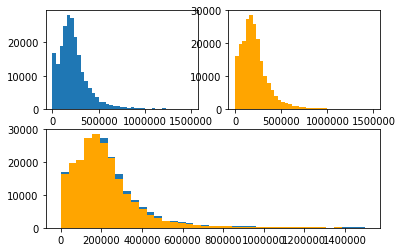

In [54]:
labels = list(train_Y_use)
#range = (0, 1000000)
bins = np.linspace(0,1500000,40)
plt.subplot(2, 2, 1)
plt.hist(np.expm1(labels),bins= bins)
plt.subplot(2, 2, 2)
plt.hist(np.expm1(train_pre), bins = bins, color = 'orange')
plt.subplot(212)
plt.hist(np.expm1(labels),bins= bins)
plt.hist(np.expm1(train_pre), bins = bins, color = 'orange')
plt.show()

In [55]:
from sklearn import linear_model

clf = linear_model.HuberRegressor()
clf.fit(train_X_use, train_Y_use)
r2 = clf.score(test_X_use, test_Y_use)
y_predict = clf.predict(test_X_use)
train_pre = clf.predict(train_X_use)

In [56]:
pererror = []
counts = 0
labels = list(train_Y_use)
for i in range(len(train_pre)):
    pererror.append((np.expm1(train_pre[i])-np.expm1(labels[i]))/np.expm1(labels[i]))
    if np.abs(pererror[i]) < 0.1:
        counts += 1
print('train', counts/len(train_pre))

pererror = []
counts = 0
labels = list(test_Y_use)
for i in range(len(y_predict)):
    pererror.append((np.expm1(y_predict[i])-np.expm1(labels[i]))/np.expm1(labels[i]))
    if np.abs(pererror[i]) < 0.1:
        counts += 1
print('test', counts/len(y_predict))

train 0.1831640628570906
test 0.2213275726630008


In [57]:
#K-NN
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neighbors import RadiusNeighborsRegressor

# model = KNeighborsRegressor(n_neighbors=200, p = 2)
# model.fit(train_X_use, np.array(train_Y_use))
# y_predict = model.predict(test_X_use)
# train_pre = model.predict(train_X_use)

In [58]:
# result for K-NN is:

# train 0.18923403205016867
# test 0.1600549882168107

In [59]:
# from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

# GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=10, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =5)

# # GBoost = RandomForestRegressor(n_estimators=1000,max_depth = 8)
# GBoost.fit(train_X_use, train_Y_use)
# r2 = GBoost.score(test_X_use, test_Y_use)
# print("[INFO] Random Forest raw pixel accuracy: {:.2f}%".format(r2 * 100))
# y_predict = GBoost.predict(test_X_use)
# train_pre = GBoost.predict(train_X_use)
